* Determine if the expansion of near-field in May is caused by decreasing of wind-induced mixing or increasing of tide-induced mixing.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import DetermineEdgePlume as DEP
import R_mixStuff as RS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
sites = {'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
        'NS':{'lat':49.17,'lon':-123.30,'j': 60,'i':61},
        'WS':{'lat':49.11,'lon':-123.40,'j': 53,'i':38}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [4]:
## load grid_T model results
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')

In [5]:
def get_Rmix(gridT1,gridT2,gridT3,tst,ted,dep_ind):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3],['river+tides','river+winds','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']
        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [6]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
    S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [7]:
def rmix_each_three(ax1, ax2,ax3,nowind_T,notide_T,all_T,tst,ted,dep_ind,S_thre,cmap):
    """This function was made to plot the averaged Rmix spatial pattern
    for river +tides and river +winds cases"""
    rmix = get_Rmix(nowind_T,notide_T,all_T,tst,ted,dep_ind)
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    levels = np.arange(0,1.1,0.1)
    for ti, ax in zip(['river+tides','river+winds','all'],[ax1,ax2,ax3]):
        CS = ax.contourf(lon[:],lat[:],rmix[ti],levels,cmap = cmap,extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
        SS,W = determine_plume_method2_onlysalinity(all_T,tst,ted,0)
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(2,))
        plt.clabel(CS3,fmt='%2.1f', colors='r',fontsize = 14)
        cbar = fig.colorbar(CS,ax = ax,orientation = 'horizontal')
        cbar.add_lines(CS2)
        cbar.set_label('Rmix')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        ax.set_ylim([48.9,49.5])

In [8]:
def salinity_each_three(ax1, ax2,ax3,nowind_T,notide_T,all_T,tst,ted,dep_ind,S_thre,cmap):
    """This function was made to plot the averaged surface salinity spatial pattern
    for river +tides and river +winds cases"""
    #rmix = get_Rmix(nowind_T,notide_T,all_T,tst,ted,dep_ind)
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    levels = np.arange(0,31,2)
    for gridT,ti, ax in zip([nowind_T,notide_T,all_T],['river+tides','river+winds','all'],[ax1,ax2,ax3]):
        SS,W = determine_plume_method2_onlysalinity(gridT,tst,ted,0)
        CS = ax.contourf(lon[:],lat[:],W,levels,cmap = cmap,extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))        
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(2,))
        plt.clabel(CS3,fmt='%2.1f', colors='r',fontsize = 14)
        cbar = fig.colorbar(CS,ax = ax,orientation = 'horizontal')
        cbar.add_lines(CS2)
        cbar.set_label('Practial Salinity')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        ax.set_ylim([48.9,49.5])

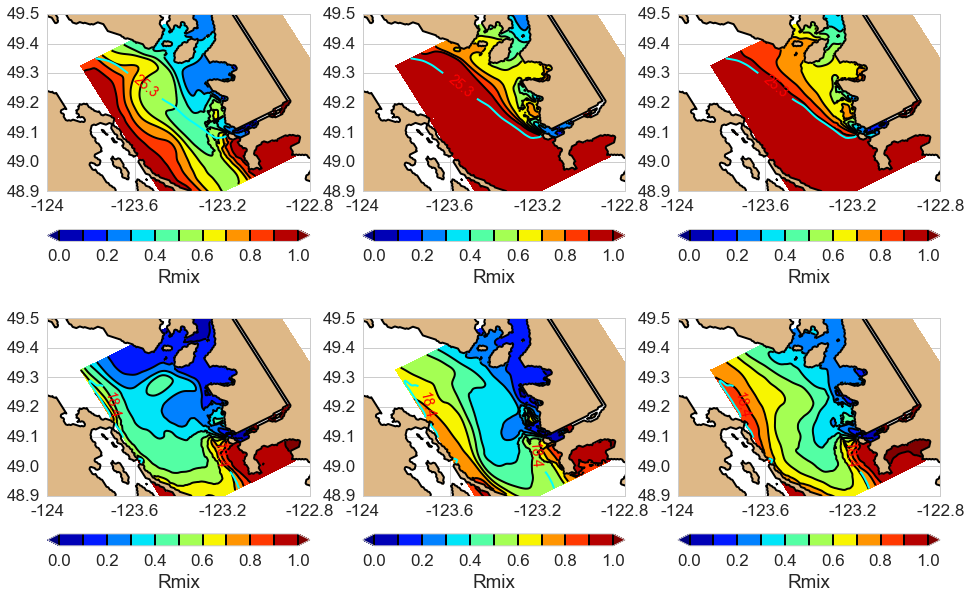

In [9]:
fig,ax  = plt.subplots(2,3,figsize=(16,10))
dep_ind = 10
cmap = 'jet'
for i,nowind_T,notide_T,all_T,tst,ted,S_thre in zip(range(2),[octnowind_T,maynowind_T],\
                                            [octnotide_T,maynotide_T],\
                                            [octall_T,mayall_T],\
                                            [408,432],\
                                            [480,503],\
                                            [25.3,18.4]):
    ax1 = ax[i,0]
    ax2 = ax[i,1]
    ax3 = ax[i,2]
    rmix_each_three(ax1,ax2,ax3,nowind_T,notide_T,all_T,tst,ted,dep_ind,S_thre,cmap)
plt.show()

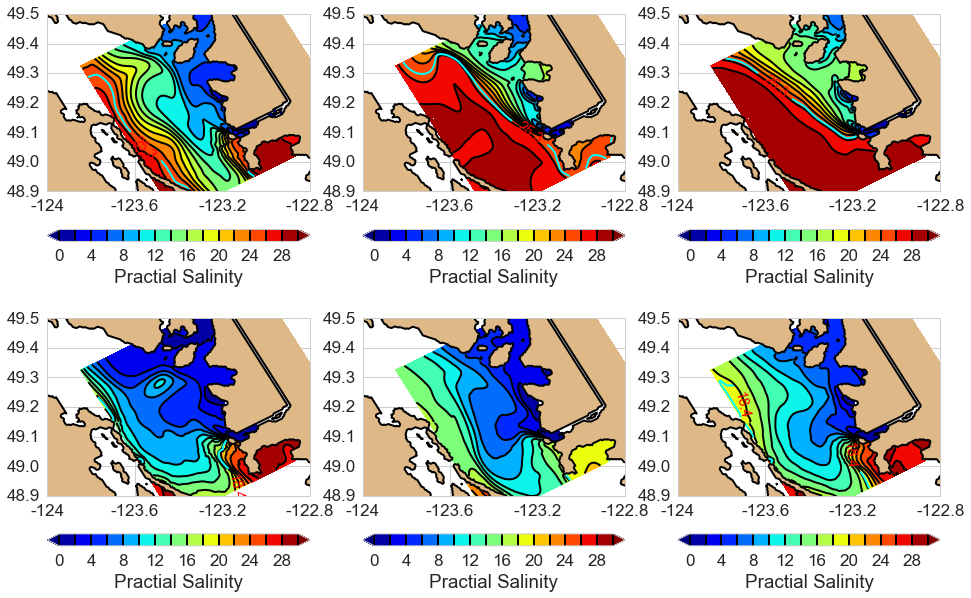

In [10]:
fig,ax  = plt.subplots(2,3,figsize=(16,10))
dep_ind = 10
cmap = 'jet'
for i,nowind_T,notide_T,all_T,tst,ted,S_thre in zip(range(2),[octnowind_T,maynowind_T],\
                                            [octnotide_T,maynotide_T],\
                                            [octall_T,mayall_T],\
                                            [408,432],\
                                            [480,503],\
                                            [25.3,18.4]):
    ax1 = ax[i,0]
    ax2 = ax[i,1]
    ax3 = ax[i,2]
    salinity_each_three(ax1,ax2,ax3,nowind_T,notide_T,all_T,tst,ted,dep_ind,S_thre,cmap)
plt.show()

# Check vertical profiles

In [9]:
def Vertical_Profile(S_season,tst,ted,stn,nowind_T,notide_T,all_T):
    """
    Plot the time averaged vertical salinity profiles at a location during a specific river flow period. 
    """

    fig,ax = plt.subplots(1,1,figsize = (6,6))
    for file, run in zip([nowind_T,notide_T,all_T],['river+tides','river+winds','all']):
        S = file.variables['vosaline']
        depth = file.variables['deptht']
        S_season[run] = np.ma.masked_values(np.nanmean(S[tst:ted+1, 0:20,sites[stn]['j'],sites[stn]['i']],
                                                       axis = 0),0)
        ax.plot(S_season[run],depth[0:20],label = run)
        ax.legend(loc = 'best')
        ax.set_ylim([20,0])
        ax.set_xlabel('Practical salinity')
        ax.set_ylabel('Depth [m]')

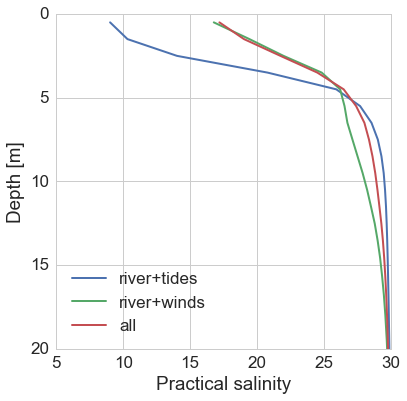

In [12]:
## October moderate wind
S_oct = {}
tst = 408
ted = 480
stn = 'NS'
Vertical_Profile(S_oct,tst,ted,stn,octnowind_T,octnotide_T,octall_T)

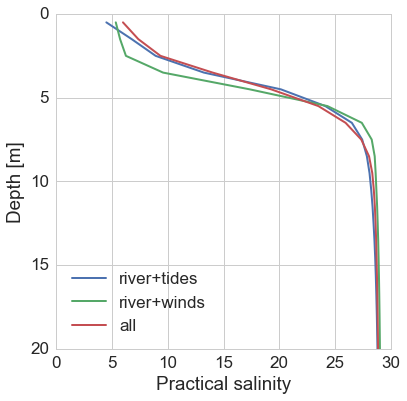

In [13]:
## May moderate wind
S_may = {}
tst = 432
ted = 503
stn = 'NS'
Vertical_Profile(S_may,tst,ted,stn,maynowind_T,maynotide_T,mayall_T)

# Salinity histogram

In [70]:
def Extract_Salinity(grid_T,tst,ted,dep,S_thre,yslices,xslices,Threshould = True):
    """
    Extract salinity in the upper layer over a domain, in order to plot the histogram
    If Threshoud is True: then extract the plume region
    if not, then extract the selected fixed domain
    """
    S = grid_T.variables['vosaline']
    S_WindEvent = np.nanmean(S[tst:ted+1],axis = 0)
    S_WindEvent = np.ma.array(S_WindEvent, mask = np_mask)
    S_Extract = []
    for z in range(dep):
        for jj in range(yslices[0],yslices[-1]):
            for ii in range(xslices[0],xslices[-1]):
                if Threshould is True:
                    if  S_WindEvent[z,jj-380,ii-240] - S_thre <= 0:
                        S_Extract.append(S_WindEvent[z,jj-380,ii-240])
                else:
                    if  S_WindEvent[z,jj-380,ii-240] is np.ma.masked:
                        continue
                    else:
                        S_Extract.append(S_WindEvent[z,jj-380,ii-240])

    return S_Extract

* If count in the whole domain:

In [85]:
yslices = [380,509]
xslices =  [240,341]
S_OctTidesDo = Extract_Salinity(octnowind_T,408,480,10,25.3,yslices,xslices,Threshould = False)
S_OctWindsDo = Extract_Salinity(octnotide_T,408,480,10,25.3,yslices,xslices,Threshould = False)

In [86]:
S_MayTidesDo = Extract_Salinity(maynowind_T,432,503,10,18.3,yslices,xslices,Threshould = False)
S_MayWindsDo = Extract_Salinity(maynotide_T,432,503,10,18.3,yslices,xslices,Threshould = False)

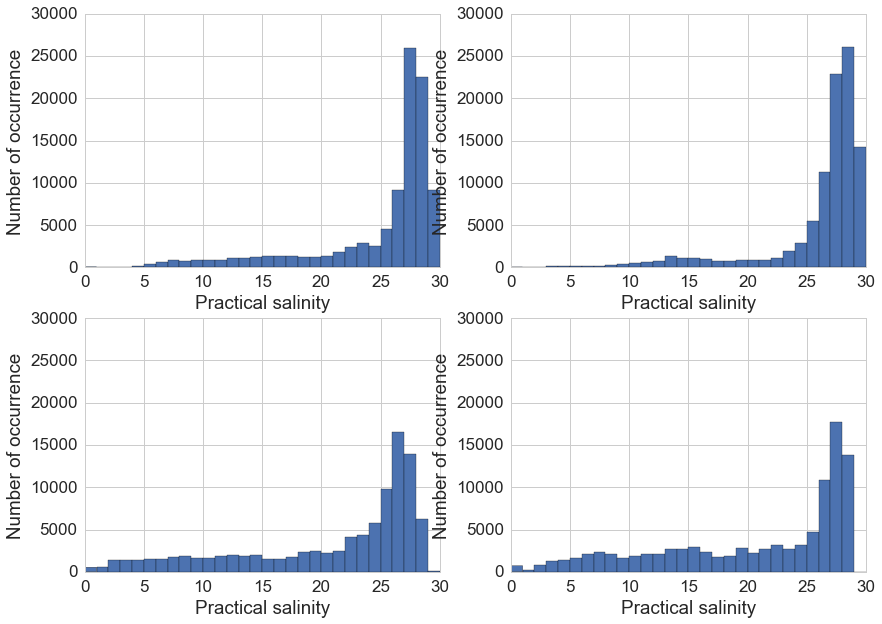

In [141]:
## original plot
fig,axs = plt.subplots(2,2,figsize = (14,10))
ax = axs[0,0]
ax.hist(S_OctTidesDo,bins = 30,range = (0,30))
ax = axs[0,1]
ax.hist(S_OctWindsDo,bins = 30,range = (0,30))
ax = axs[1,0]
ax.hist(S_MayTidesDo,bins = 30,range = (0,30))
ax = axs[1,1]
ax.hist(S_MayWindsDo,bins = 30,range = (0,30))
for ax in axs.flatten():
    ax.set_ylim([0,3e4])
    ax.set_xlim([0,30])
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

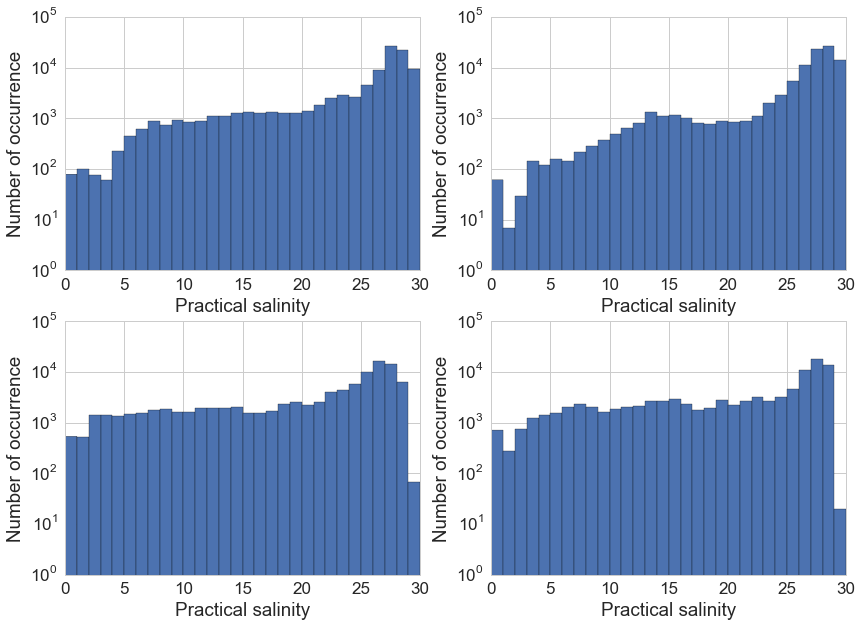

In [140]:
## log scale plot
fig,axs = plt.subplots(2,2,figsize = (14,10))
ax = axs[0,0]
ax.hist(S_OctTidesDo,bins = 30,range = (0,30))
ax = axs[0,1]
ax.hist(S_OctWindsDo,bins = 30,range = (0,30))
ax = axs[1,0]
ax.hist(S_MayTidesDo,bins = 30,range = (0,30))
ax = axs[1,1]
ax.hist(S_MayWindsDo,bins = 30,range = (0,30))
for ax in axs.flatten():
    ax.set_ylim([1e0,1e5])
    ax.set_xlim([0,30])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

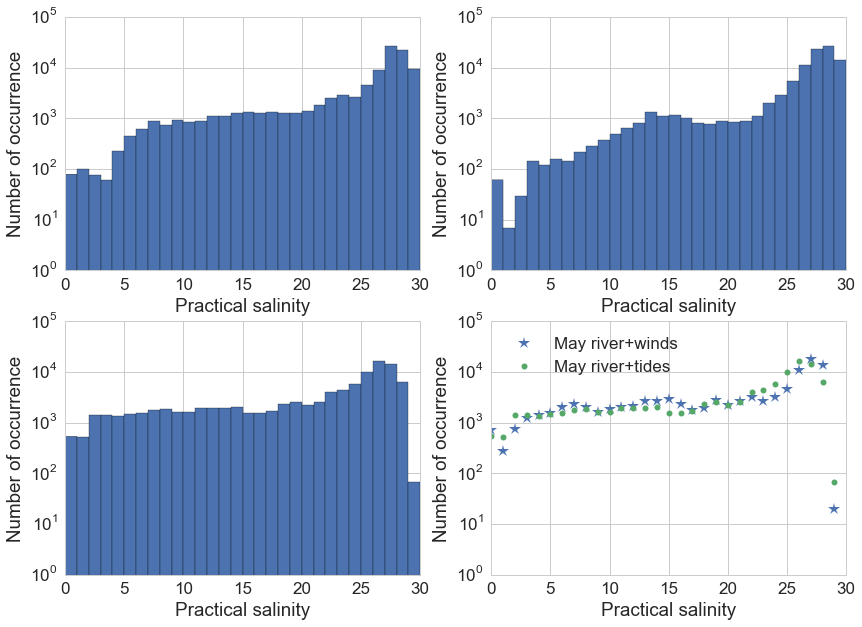

In [139]:
## log scale plot with May on top of each other in the last panel
fig,axs = plt.subplots(2,2,figsize = (14,10))
ax = axs[0,0]
ax.hist(S_OctTidesDo,bins = 30,range = (0,30))
ax = axs[0,1]
ax.hist(S_OctWindsDo,bins = 30,range = (0,30))
ax = axs[1,0]
ax.hist(S_MayTidesDo,bins = 30,range = (0,30))
ax = axs[1,1]
Counts_May_Winds,bin_edgeWind = np.histogram(S_MayWindsDo,bins = 30,range = (0,30)) ## return the counts in a salinity bin
Counts_May_Tides,bin_edgeTide = np.histogram(S_MayTidesDo,bins = 30,range = (0,30))
#ax.hist(S_MayWindsDo,bins = 30,label ='May river+winds')
#ax.hist(S_MayTidesDo,bins = 30,label = 'May river+tides')
ax.plot(Counts_May_Winds, '*',label = 'May river+winds',markersize = 12)
ax.plot(Counts_May_Tides, '.',label = 'May river+tides',markersize = 12)
ax.legend(loc = 'best')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e5])
    ax.set_xlim([0,30])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

* strong wind in May

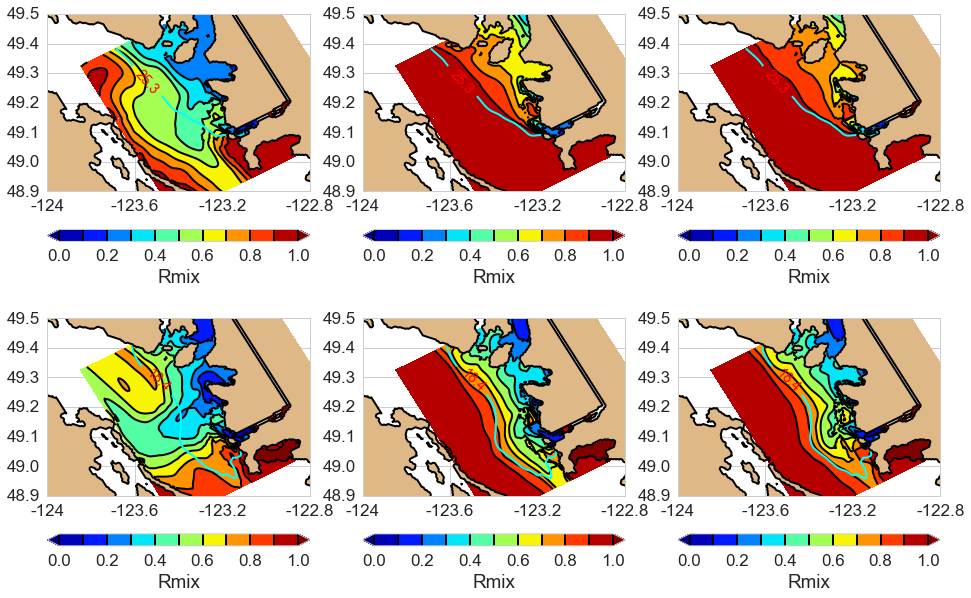

In [26]:
fig,ax  = plt.subplots(2,3,figsize=(16,10))
dep_ind = 10
cmap = 'jet'
for i,nowind_T,notide_T,all_T,tst,ted,S_thre in zip(range(2),[octnowind_T,maynowind_T],\
                                            [octnotide_T,maynotide_T],\
                                            [octall_T,mayall_T],\
                                            [480,24],\
                                            [551,71],\
                                            [25.3,18.4]):
    ax1 = ax[i,0]
    ax2 = ax[i,1]
    ax3 = ax[i,2]
    rmix_each_three(ax1,ax2,ax3,nowind_T,notide_T,all_T,tst,ted,dep_ind,S_thre,cmap)
plt.show()

In [90]:
S_MayTidesHigh = Extract_Salinity(maynowind_T,24,71,10,18.3,yslices,xslices,Threshould = False)
S_MayWindsHigh = Extract_Salinity(maynotide_T,24,71,10,18.3,yslices,xslices,Threshould = False)

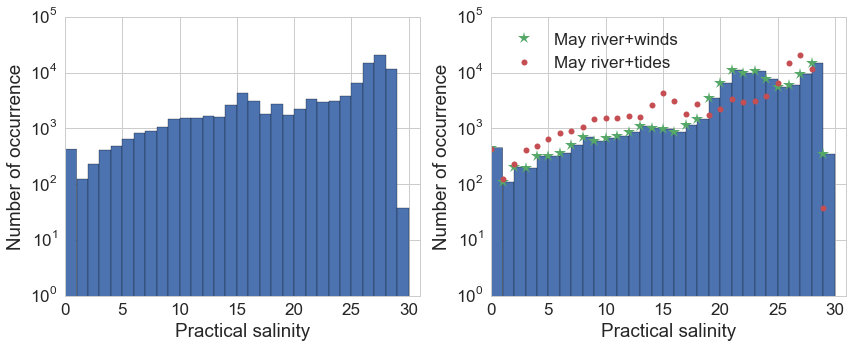

In [133]:
## log scale plot with May for strong wind
fig,axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
ax.hist(S_MayTidesHigh,bins = 30,range=(0,30))
ax = axs[1]
ax.hist(S_MayWindsHigh,bins = 30,range=(0,30))
Counts_May_Winds,bin_edgeWind = np.histogram(S_MayWindsHigh,bins = 30,range=(0,30)) ## return the counts in a salinity bin
Counts_May_Tides,bin_edgeTide = np.histogram(S_MayTidesHigh,bins = 30,range=(0,30))
#ax.hist(S_MayWindsDo,bins = 30,label ='May river+winds')
#ax.hist(S_MayTidesDo,bins = 30,label = 'May river+tides')
ax.plot(Counts_May_Winds, '*',label = 'May river+winds',markersize = 12)
ax.plot(Counts_May_Tides, '.',label = 'May river+tides',markersize = 12)
ax.legend(loc = 'best')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e5])
    ax.set_xlim([0,31])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

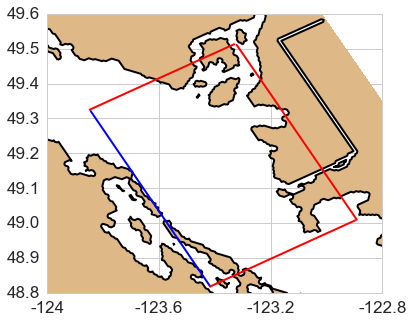

In [19]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_xlim([-124.,-122.8])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.8,49.6])
ax.plot(X[yslices[0]: yslices[-1], xslices[0]],Y[yslices[0]: yslices[-1], xslices[0]] , 'b-')
ax.plot(X[yslices[0]: yslices[-1], xslices[-1]],Y[yslices[0]: yslices[-1], xslices[-1]] , 'r-')
ax.plot(X[yslices[0], xslices[0]:xslices[-1]],Y[yslices[0], xslices[0]:xslices[-1]], 'r-')
ax.plot(X[yslices[-1], xslices[0]:xslices[-1]],Y[yslices[-1], xslices[0]:xslices[-1]] , 'r-')

# Smaller domain

In [73]:
yslices = [420,440]
xslices =  [300,312]

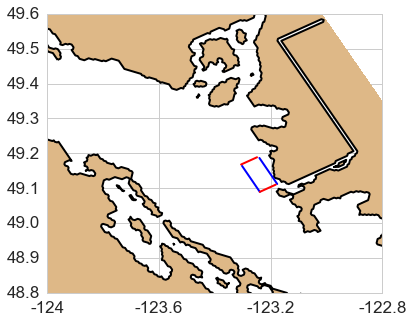

In [59]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_xlim([-124.,-122.8])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.8,49.6])
ax.plot(X[420:440,300],Y[420:440,300] , 'b-')
ax.plot(X[420:440,312],Y[420:440,312] , 'b-')
ax.plot(X[420,300:312],Y[420,300:312], 'r-')
ax.plot(X[440,300:312],Y[440,300:312] , 'r-')

In [74]:
## moderate wind
S_OctTidesSm = Extract_Salinity(octnowind_T,408,480,10,25.3,yslices,xslices,Threshould = False)
S_OctWindsSm = Extract_Salinity(octnotide_T,408,480,10,25.3,yslices,xslices,Threshould = False)
S_MayTidesSm = Extract_Salinity(maynowind_T,432,503,10,18.3,yslices,xslices,Threshould = False)
S_MayWindsSm = Extract_Salinity(maynotide_T,432,503,10,18.3,yslices,xslices,Threshould = False)

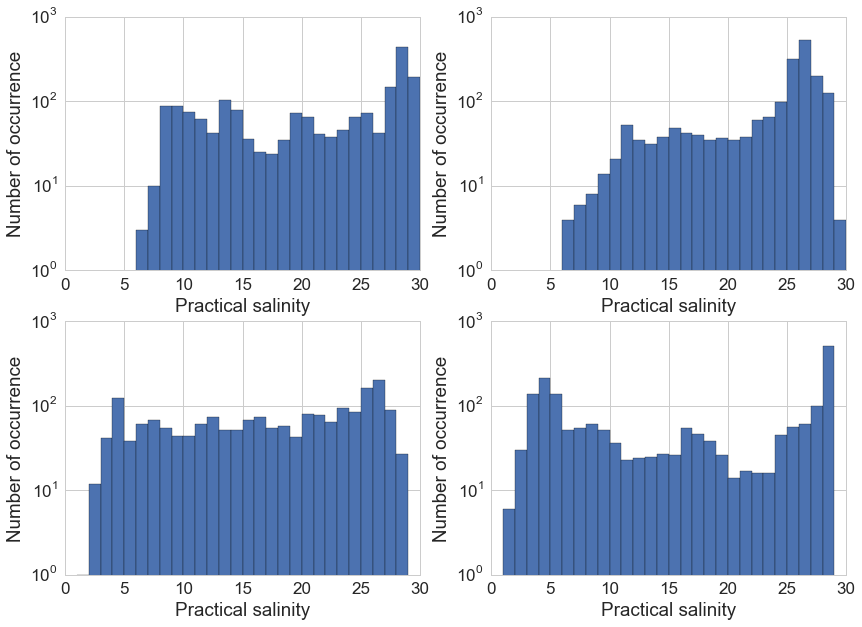

In [136]:
## log scale plot
fig,axs = plt.subplots(2,2,figsize = (14,10))
ax = axs[0,0]
ax.hist(S_OctTidesSm,bins = 30, range = (0,30))
ax = axs[0,1]
ax.hist(S_OctWindsSm,bins = 30, range = (0,30))
ax = axs[1,0]
ax.hist(S_MayTidesSm,bins = 30, range = (0,30))
ax = axs[1,1]
ax.hist(S_MayWindsSm,bins = 30, range = (0,30))
for ax in axs.flatten():
    ax.set_ylim([1e0,1e3])
    ax.set_xlim([0,30])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

In [81]:
## strong wind May
S_MayTidesHighSm = Extract_Salinity(maynowind_T,24,71,10,18.3,yslices,xslices,Threshould = False)
S_MayWindsHighSm = Extract_Salinity(maynotide_T,24,71,10,18.3,yslices,xslices,Threshould = False)

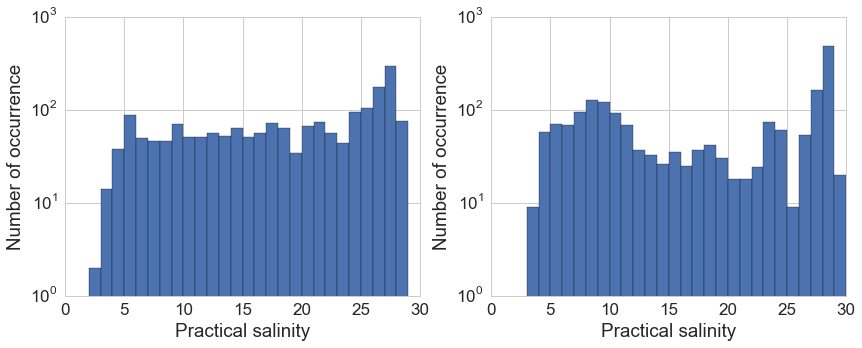

In [137]:
## log scale plot
fig,axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
ax.hist(S_MayTidesHighSm,bins = 30, range = (0,30))
ax = axs[1]
ax.hist(S_MayWindsHighSm,bins = 30, range = (0,30))
ax.legend(loc = 'best')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e3])
    ax.set_xlim([0,30])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()

# 13 spatial grid points at the river mouth

In [92]:
yslices = [417,430]
xslices =  [309,310]

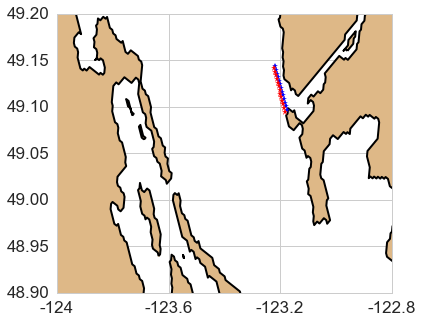

In [43]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_xlim([-124.,-122.8])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.9,49.2])
#ax.plot(X[410:430,287],Y[410:430,287] , 'b*')
ax.plot(X[417:430,310],Y[417:430,310] , 'b*')
ax.plot(X[417:430,309],Y[417:430,309] , 'r*')
#ax.plot(X[410,287:312],Y[410,287:312], 'r-')
#ax.plot(X[430,287:312],Y[430,287:312] , 'r-')

In [93]:
## moderate wind
S_OctTidesSmm = Extract_Salinity(octnowind_T,408,480,10,25.3,yslices,xslices,Threshould = False)
S_OctWindsSmm = Extract_Salinity(octnotide_T,408,480,10,25.3,yslices,xslices,Threshould = False)
S_MayTidesSmm = Extract_Salinity(maynowind_T,432,503,10,18.3,yslices,xslices,Threshould = False)
S_MayWindsSmm = Extract_Salinity(maynotide_T,432,503,10,18.3,yslices,xslices,Threshould = False)

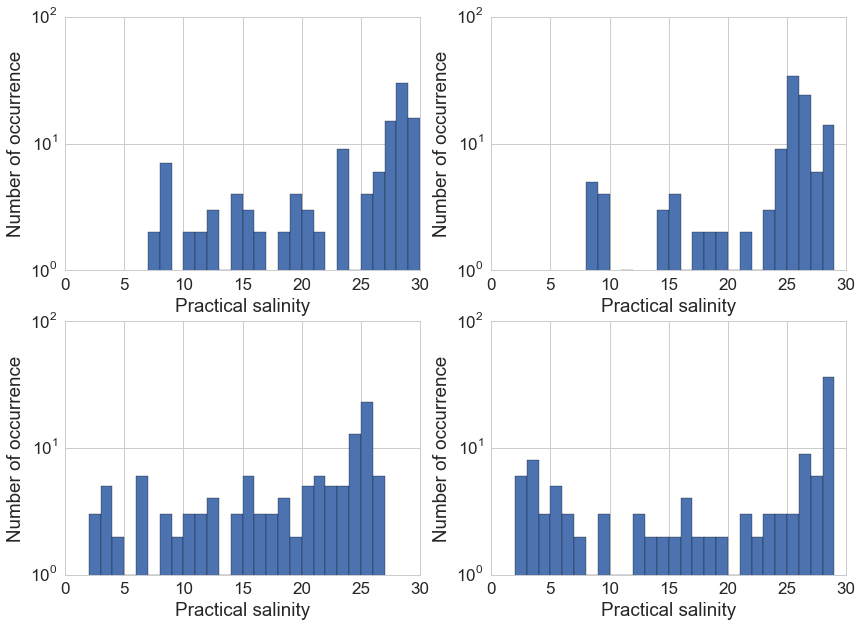

In [138]:
## log scale plot
fig,axs = plt.subplots(2,2,figsize = (14,10))
ax = axs[0,0]
ax.hist(S_OctTidesSmm,bins = 30, range = (0,30))
ax = axs[0,1]
ax.hist(S_OctWindsSmm,bins = 30, range = (0,30))
ax = axs[1,0]
ax.hist(S_MayTidesSmm,bins = 30, range = (0,30))
ax = axs[1,1]
ax.hist(S_MayWindsSmm,bins = 30, range = (0,30))
ax.legend(loc = 'best')
for ax in axs.flatten():
    ax.set_ylim([1e0,1e2])
    ax.set_xlim([0,30])
    ax.set_yscale('log')
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()